In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import stat                                                                         
from sklearn.model_selection import train_test_split

In [2]:
df1=pd.read_csv('heartrate_seconds_merged.csv')
df1=df1.drop(['Id'],axis=1)
df1.head()


Time  Value
0  4/12/2016 7:21:00 AM     97
1  4/12/2016 7:21:05 AM    102
2  4/12/2016 7:21:10 AM    105
3  4/12/2016 7:21:20 AM    103
4  4/12/2016 7:21:25 AM    101

In [3]:
df2=pd.read_csv('minuteCaloriesNarrow_merged.csv')
df2=df2.drop(['Id'],axis=1)
df2.rename(columns = {'ActivityMinute':'Time'}, inplace = True)
df2.head()

Time  Calories
0  4/12/2016 12:00:00 AM    0.7865
1  4/12/2016 12:01:00 AM    0.7865
2  4/12/2016 12:02:00 AM    0.7865
3  4/12/2016 12:03:00 AM    0.7865
4  4/12/2016 12:04:00 AM    0.7865

In [4]:
df=pd.merge(left = df1, right = df2, how = 'inner')
df.head()

Time  Value  Calories
0  4/12/2016 7:21:00 AM     97    0.7865
1  4/12/2016 7:21:00 AM     97    0.8310
2  4/12/2016 7:21:00 AM     97    1.4053
3  4/12/2016 7:21:00 AM     97    0.9357
4  4/12/2016 7:21:00 AM     97    1.4060

In [5]:
df.tail()

Time  Value  Calories
6117857  5/12/2016 7:16:00 AM     83   0.90020
6117858  5/12/2016 7:16:00 AM     83   1.24487
6117859  5/12/2016 7:16:00 AM     83   1.21410
6117860  5/12/2016 7:16:00 AM     83   1.80180
6117861  5/12/2016 7:16:00 AM     83   1.81845

In [6]:
df.shape

(6117862, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6117862 entries, 0 to 6117861
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Time      object 
 1   Value     int64  
 2   Calories  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 186.7+ MB


In [8]:
df['Time'] = pd.to_datetime(df['Time'])


In [9]:
#Splitting the test day
df_test = df.loc[(df.Time > '4/16/2016 10:30:00 AM') & (df.Time < '4/17/2016 10:30:00 AM')]
df = df.loc[(df.Time < '4/16/2016 10:30:00 AM') | (df.Time > '4/17/2016 10:30:00 AM')]
df=df.drop(['Time'],axis=1)
df_test=df_test.drop(['Time'],axis=1)

In [10]:
df_test

Value  Calories
385208      87   0.94380
385209      87   0.83100
385210      87   1.40530
385211      87   1.12284
385212      87   1.43270
...        ...       ...
6115654    103   0.99140
6115655    103   4.50450
6115656    103   1.40250
6115657    103   1.17270
6115658    103   1.22260

[219680 rows x 2 columns]

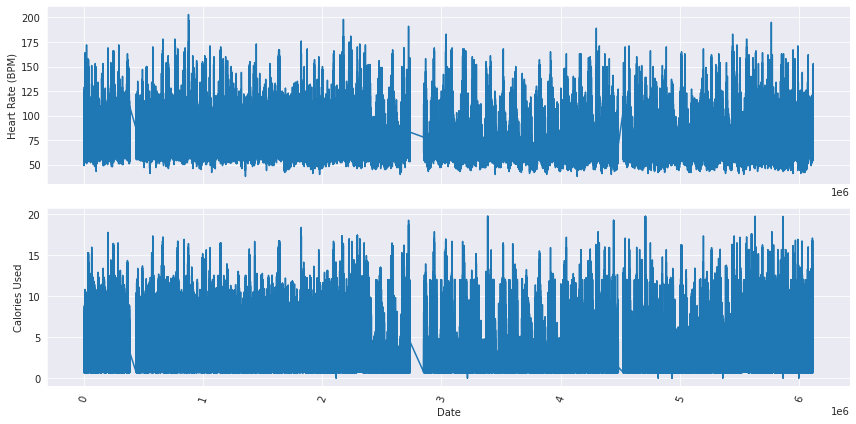

In [11]:
#Visualising training and testing data
datasets = [df, df_test]
for dfs in datasets:
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
    axs[0].plot(dfs['Value'])
    axs[1].plot(dfs['Calories'])
    plt.setp(axs[0].get_xticklabels(), visible=False)
    axs[0].tick_params(axis='x', rotation=70)
    axs[1].tick_params(axis='x', rotation=70)
    axs[0].set(ylabel='Heart Rate (BPM)')
    axs[1].set(ylabel= 'Calories Used', xlabel="Date")
    plt.tight_layout()
    plt.show

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


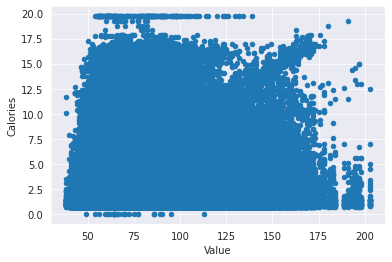

In [12]:
df.plot.scatter(x = 'Value', y = 'Calories');

In [13]:
print(df.corr())

             Value  Calories
Value     1.000000  0.104971
Calories  0.104971  1.000000


In [14]:
#sligtly positive correlation

Getting back to the code, we now need to scale our data so that we can reduce the impact of any outliers within our training data that may impede a model’s ability to detect anomalies. We will use the MinMaxScaler as this will change both the heart rate and calories data to be between 0 and 1, which will be important later when we calculate prediction errors.



In [15]:
#Scale the data
#
#Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(df)
scale_df = pd.DataFrame(scaler.transform(df))
scale_test = pd.DataFrame(scaler.transform(df_test))
scale_df


0         1
0        0.357576  0.039869
1        0.357576  0.042124
2        0.357576  0.071236
3        0.357576  0.047432
4        0.357576  0.071272
...           ...       ...
5897889  0.272727  0.045632
5897890  0.272727  0.063104
5897891  0.272727  0.061544
5897892  0.272727  0.091335
5897893  0.272727  0.092179

[5897894 rows x 2 columns]

In [16]:
# import random
# random.seed(10)

#scale_df.sample(100000)
scale_df=scale_df.iloc[0:10000,:]
scale_df

0         1
0     0.357576  0.039869
1     0.357576  0.042124
2     0.357576  0.071236
3     0.357576  0.047432
4     0.357576  0.071272
...        ...       ...
9995  0.284848  0.456676
9996  0.284848  0.071094
9997  0.284848  0.059445
9998  0.284848  0.161425
9999  0.157576  0.135553

[10000 rows x 2 columns]

In [17]:
scale_test=scale_test.iloc[0:2000,:]
scale_test

0         1
0     0.296970  0.047842
1     0.296970  0.042124
2     0.296970  0.071236
3     0.296970  0.056918
4     0.296970  0.072625
...        ...       ...
1995  0.284848  0.039183
1996  0.284848  0.069721
1997  0.284848  0.194745
1998  0.284848  0.085951
1999  0.284848  0.139834

[2000 rows x 2 columns]

In [18]:
# reshape to [samples, time_steps, n_features]
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
time_steps = 30


In [19]:
X_train, y_train = create_dataset(scale_df, scale_df, time_steps)
print(X_train.shape, y_train.shape)

(9970, 30, 2) (9970, 2)


In [20]:
X_test, y_test = create_dataset(scale_test, scale_test, time_steps)
print(X_test.shape, y_test.shape)

(1970, 30, 2) (1970, 2)


In [21]:
#model building
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, name='encoder_1'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(128, return_sequences=True, name='encoder_2'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(64, return_sequences=False, name='encoder_3'))
model.add(keras.layers.RepeatVector(n=X_train.shape[1], name='encoder_decoder'))
model.add(keras.layers.LSTM(64, return_sequences=True, name='decoder_1'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(128, return_sequences=True, name='decoder_2'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(256, return_sequences=True, name='decoder_3'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 30, 256)           265216    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 encoder_2 (LSTM)            (None, 30, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 encoder_3 (LSTM)            (None, 64)                49408     
                                                                 
 encoder_decoder (RepeatVect  (None, 30, 64)           0         
 or)                                                             
                                                        

In [22]:
#fitting on training data
history = model.fit(X_train, X_train, epochs=10, batch_size=256,
                    validation_split=0.1,verbose=1,shuffle=False)
#plotting loss
fig=plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('No. Epochs')
plt.legend()
plt.show()

Epoch 1/10
36/36 [==============================] - 77s 2s/step - loss: 0.0643 - val_loss: 0.0660
Epoch 2/10
36/36 [==============================] - 57s 2s/step - loss: 0.0458 - val_loss: 0.0486
Epoch 3/10
36/36 [==============================] - 56s 2s/step - loss: 0.0383 - val_loss: 0.0463
Epoch 4/10
36/36 [==============================] - 57s 2s/step - loss: 0.0362 - val_loss: 0.0421
Epoch 5/10
36/36 [==============================] - 57s 2s/step - loss: 0.0329 - val_loss: 0.0397
Epoch 6/10
36/36 [==============================] - 56s 2s/step - loss: 0.0327 - val_loss: 0.0406
Epoch 7/10
36/36 [==============================] - 61s 2s/step - loss: 0.0311 - val_loss: 0.0390
Epoch 8/10
36/36 [==============================] - 56s 2s/step - loss: 0.0309 - val_loss: 0.0396
Epoch 9/10
36/36 [==============================] - 57s 2s/step - loss: 0.0314 - val_loss: 0.0386
Epoch 10/10
36/36 [==============================] - 58s 2s/step - loss: 0.0296 - val_loss: 0.0362


312/312 [==============================] - 42s 126ms/step


<ipython-input-23-00903fd27b83>:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(anomaly, bins=50, kde = True)


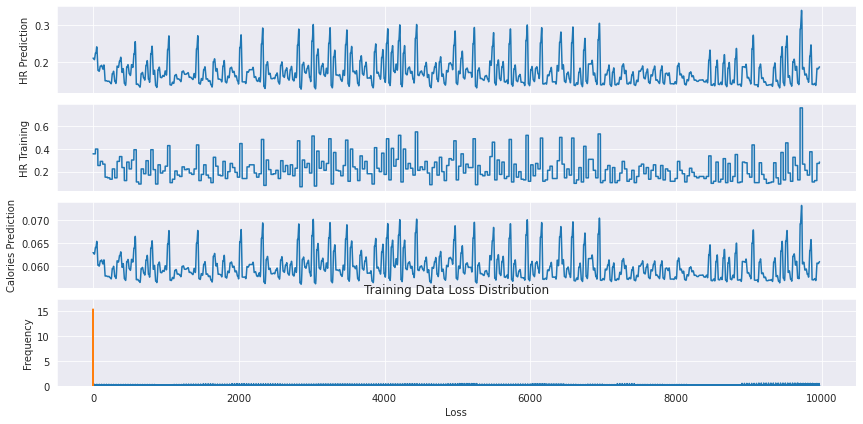

In [23]:
#predicting on test data
X_pred = model.predict(X_train)
X_pred_2d = pd.DataFrame(X_pred[:,0,:]).astype(float)
X_pred_2d.columns = ['HR Pred', 'Calories Pred']
X_train_2d = pd.DataFrame(X_train[:,0,:]).astype(float)
X_train_2d.columns = ['HR Test', 'Calories Test']
#Plot the test data together
fig, axs = plt.subplots(4, figsize=(12,6))
axs[0].plot(X_pred_2d['HR Pred'])
axs[1].plot(X_train_2d['HR Test'])
axs[2].plot(X_pred_2d['Calories Pred'])
axs[3].plot(X_train_2d['Calories Test'])
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[2].get_xticklabels(), visible=False)
axs[0].tick_params(axis='x', rotation=70)
axs[1].tick_params(axis='x', rotation=70)
axs[0].set(ylabel= 'HR Prediction')
axs[1].set(ylabel= 'HR Training')
axs[2].set(ylabel= 'Calories Prediction')
axs[3].set(ylabel= 'Calories Training', xlabel= 'Time Step (per minute)')
plt.tight_layout()
#calculate error
predictions = pd.concat([X_pred_2d['HR Pred'], X_pred_2d['Calories Pred']], axis = 1)
train_inputs = pd.concat([X_train_2d['HR Test'], X_train_2d['Calories Test']], axis = 1)
anomaly = pd.DataFrame(np.abs(predictions.values - train_inputs.values))
anomaly = anomaly.mean(axis=1)
ax = sns.distplot(anomaly, bins=50, kde = True)
ax.set_title('Training Data Loss Distribution')
ax.set_xlabel('Loss')
ax.set_ylabel('Frequency')
fig = ax.get_figure()

In [24]:
thres = round(np.quantile(anomaly, 0.99),3)
print('99th percentile loss value from training: ' + str(thres))

99th percentile loss value from training: 0.231


In [25]:
#pred
def pred(X_test):
  X_pred = model.predict(X_test)
  X_pred = pd.DataFrame(X_pred[:,0,:]).astype(float)
  X_pred.columns = ['HR Pred', 'Calories Pred']
  X_test_data = pd.DataFrame(X_test[:,0,:]).astype(float)
  X_test_data.columns = ['HR Test', 'Calories Test']
  difference = pd.DataFrame(np.abs(X_pred.values - X_test_data.values))
  difference['mae loss'] = difference.mean(axis=1)
  difference['threshold'] = thres
  difference['anomaly'] = difference['mae loss'] > difference['threshold'] 
  difference['index'] = difference.index
  X_pred['index'] = X_pred.index
  X_test_data['index'] = X_test_data.index
  X_test_data = X_test_data.join(difference['anomaly'])
  return X_test_data.anomaly
pred(X_test[[[0]]])

1/1 [==============================] - 0s 49ms/step


<ipython-input-25-650cdbb3539b>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred(X_test[[[0]]])


0    False
Name: anomaly, dtype: bool

In [26]:
  X_test[[[0]]]

<ipython-input-26-aa758556a92d>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test[[[0]]]


array([[[0.2969697 , 0.04784224],
        [0.2969697 , 0.04212429],
        [0.2969697 , 0.07123617],
        [0.2969697 , 0.05691797],
        [0.2969697 , 0.07262511],
        [0.2969697 , 0.28405152],
        [0.2969697 , 0.04321972],
        [0.2969697 , 0.13058022],
        [0.2969697 , 0.14304009],
        [0.2969697 , 0.04452198],
        [0.2969697 , 0.12326956],
        [0.2969697 , 0.03918268],
        [0.2969697 , 0.06972051],
        [0.2969697 , 0.05637355],
        [0.2969697 , 0.09917456],
        [0.2969697 , 0.06409076],
        [0.2969697 , 0.12232061],
        [0.2969697 , 0.07100806],
        [0.2969697 , 0.04643303],
        [0.2969697 , 0.37180285],
        [0.2969697 , 0.16858636],
        [0.2969697 , 0.07253893],
        [0.2969697 , 0.06480854],
        [0.2969697 , 0.12785506],
        [0.2969697 , 0.16442158],
        [0.2969697 , 0.0573671 ],
        [0.2969697 , 0.06172146],
        [0.2969697 , 0.05025514],
        [0.2969697 , 0.09133519],
        [0.296

In [27]:
#Predicting
X_pred = model.predict(X_test)
X_pred = pd.DataFrame(X_pred[:,0,:]).astype(float)
X_pred.columns = ['HR Pred', 'Calories Pred']
X_test_data = pd.DataFrame(X_test[:,0,:]).astype(float)
X_test_data.columns = ['HR Test', 'Calories Test']

62/62 [==============================] - 8s 135ms/step


In [28]:
difference = pd.DataFrame(np.abs(X_pred.values - X_test_data.values))
difference['mae loss'] = difference.mean(axis=1)
difference['threshold'] = thres
difference['anomaly'] = difference['mae loss'] > difference['threshold']
difference['index'] = difference.index
X_pred['index'] = X_pred.index
X_test_data['index'] = X_test_data.index
X_test_data = X_test_data.join(difference['anomaly'])


In [29]:
difference

0         1  mae loss  threshold  anomaly  index
0     0.106160  0.013481  0.059820      0.231    False      0
1     0.106199  0.019196  0.062697      0.231    False      1
2     0.106242  0.009920  0.058081      0.231    False      2
3     0.106273  0.004395  0.055334      0.231    False      3
4     0.106297  0.011314  0.058806      0.231    False      4
...        ...       ...       ...        ...      ...    ...
1965  0.037508  0.136216  0.086862      0.231    False   1965
1966  0.037994  0.027465  0.032730      0.231    False   1966
1967  0.038318  0.081380  0.059849      0.231    False   1967
1968  0.038399  0.006689  0.022544      0.231    False   1968
1969  0.038208  0.126174  0.082191      0.231    False   1969

[1970 rows x 6 columns]

In [30]:
X_test[0]

array([[0.2969697 , 0.04784224],
       [0.2969697 , 0.04212429],
       [0.2969697 , 0.07123617],
       [0.2969697 , 0.05691797],
       [0.2969697 , 0.07262511],
       [0.2969697 , 0.28405152],
       [0.2969697 , 0.04321972],
       [0.2969697 , 0.13058022],
       [0.2969697 , 0.14304009],
       [0.2969697 , 0.04452198],
       [0.2969697 , 0.12326956],
       [0.2969697 , 0.03918268],
       [0.2969697 , 0.06972051],
       [0.2969697 , 0.05637355],
       [0.2969697 , 0.09917456],
       [0.2969697 , 0.06409076],
       [0.2969697 , 0.12232061],
       [0.2969697 , 0.07100806],
       [0.2969697 , 0.04643303],
       [0.2969697 , 0.37180285],
       [0.2969697 , 0.16858636],
       [0.2969697 , 0.07253893],
       [0.2969697 , 0.06480854],
       [0.2969697 , 0.12785506],
       [0.2969697 , 0.16442158],
       [0.2969697 , 0.0573671 ],
       [0.2969697 , 0.06172146],
       [0.2969697 , 0.05025514],
       [0.2969697 , 0.09133519],
       [0.2969697 , 0.07109424]])

In [31]:
X_test_data_original = pd.DataFrame(scaler.inverse_transform(X_test_data[['HR Test','Calories Test']]))
X_test_data = pd.concat([X_test_data, X_test_data_original], axis = 1)
X_test_data.columns = ['HR Test', 'Calories Test', 'Index', 'Anomaly', 'Heart Rate (BPM)', 'Calories Used']

/usr/local/lib/python3.9/dist-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


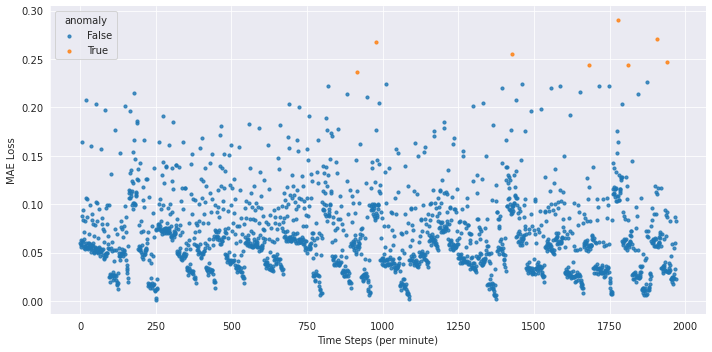

In [32]:
plt = sns.lmplot(x='index', y='mae loss', data=difference, 
           fit_reg=False, hue='anomaly', scatter_kws={"s": 10}, legend=True, legend_out=False, height=5, aspect=2)
plt.set(xlabel='Time Steps (per minute)', ylabel='MAE Loss')

/usr/local/lib/python3.9/dist-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


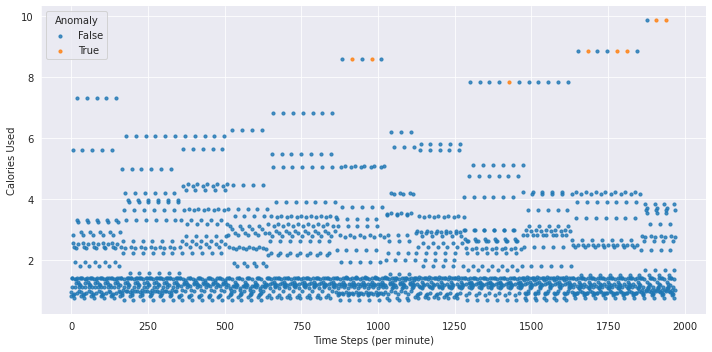

In [33]:
plt = sns.lmplot(x ='Index', y='Calories Used', scatter_kws={"s": 10}, data=X_test_data, 
           fit_reg=False, hue='Anomaly', legend=True, legend_out=False, height=5, aspect=2)
plt.set(xlabel='Time Steps (per minute)', ylabel='Calories Used')

In [34]:
# reshape to [samples, time_steps, n_features]
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps+1)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

def input(df_test):
  scale_test =pd.DataFrame(scaler.transform(df_test))
  time_steps=0
  X_test, y_test = create_dataset(scale_test, scale_test, time_steps)
  #print(X_test.shape, y_test.shape)
  X_pred = model.predict(X_test)
  X_pred = pd.DataFrame(X_pred[:,0,:]).astype(float)
  X_pred.columns = ['HR Pred', 'Calories Pred']
  X_test_data = pd.DataFrame(X_test[:,0,:]).astype(float)
  X_test_data.columns = ['HR Test', 'Calories Test']
  difference = pd.DataFrame(np.abs(X_pred.values - X_test_data.values))
  difference['mae loss'] = difference.mean(axis=1)
  difference['threshold'] = thres
  difference['anomaly'] = (difference['mae loss'] > difference['threshold']) & (difference.iloc[0,1]<0.101382)
  difference['index'] = difference.index
  X_pred['index'] = X_pred.index
  X_test_data['index'] = X_test_data.index
  X_test_data = X_test_data.join(difference['anomaly'])
  return X_test_data.anomaly[0]



def pred(X_test):
  X_pred = model.predict(X_test)
  X_pred = pd.DataFrame(X_pred[:,0,:]).astype(float)
  X_pred.columns = ['HR Pred', 'Calories Pred']
  X_test_data = pd.DataFrame(X_test[:,0,:]).astype(float)
  X_test_data.columns = ['HR Test', 'Calories Test']
  difference = pd.DataFrame(np.abs(X_pred.values - X_test_data.values))
  difference['mae loss'] = difference.mean(axis=1)
  difference['threshold'] = thres
  difference['anomaly'] = (difference['mae loss'] > difference['threshold']) & (difference.iloc[0,1]<0.101382)
  difference['index'] = difference.index
  X_pred['index'] = X_pred.index
  X_test_data['index'] = X_test_data.index
  X_test_data = X_test_data.join(difference['anomaly'])
  return X_test_data.anomaly



In [35]:
# initialize list of lists
data = [[150, 1.5]]
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Value', 'Calories'])
res=input(df)
res


1/1 [==============================] - 2s 2s/step


True

In [ ]:
# import pickle
# pickle.dump(model,open('model.pkl','wb'))

In [38]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 K

In [39]:
import gradio as gr
def predi(hr, cal):
  data = [[hr, cal]]
  # Create the pandas DataFrame
  df = pd.DataFrame(data, columns=['Value', 'Calories'])
  res=input(df)
  return res

demo = gr.Interface(
    fn=predi,
    inputs=["number", "number"],
    outputs=["text"],
)
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>